In [90]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, accuracy_score


#  STEP 1: Load and Clean the Data


df = pd.read_csv("realestate_data_london_2024_nov.csv")

# Remove entries with POA (price on application)
df = df[~df['price'].astype(str).str.contains("POA", na=False)]
df['price'] = df['price'].replace('[£,]', '', regex=True).astype(float)

# Drop if essential values are missing
df.dropna(subset=['price', 'bedrooms', 'bathrooms', 'title'], inplace=True)
df['sizeSqFeetMax'] = df['sizeSqFeetMax'].fillna(df['sizeSqFeetMax'].median())


#  STEP 2: Extract Region from Title (via Postcode)

# Extract postcode (last valid UK code pattern at end of title)
df['postcode'] = df['title'].str.extract(r'([A-Z]{1,2}\d{1,2}[A-Z]?)\s*,?\s*$')
df['postcode_prefix'] = df['postcode'].str.extract(r'^([A-Z]{1,2})')

# Map postcode prefix to broader London regions
postcode_to_region = {
    'N': 'North', 'NW': 'North',
    'E': 'East',
    'S': 'South', 'SE': 'South', 'SW': 'South',
    'W': 'West',
    'WC': 'Central', 'EC': 'Central'
}

df['region'] = df['postcode_prefix'].map(postcode_to_region).fillna('Other')

# One-hot encode region
df = pd.get_dummies(df, columns=['region'], prefix='region', prefix_sep='_', drop_first=False)


#  STEP 3: Feature Engineering


df['price_per_bedroom'] = df['price'] / df['bedrooms']
df['price_per_sqft'] = df['price'] / df['sizeSqFeetMax']
df['estimated_rent'] = df['price'] * np.random.uniform(0.0035, 0.0065, size=len(df))
df['rental_yield'] = (df['estimated_rent'] * 12) / df['price'] * 100
df['expected_growth_rate'] = np.random.uniform(0.02, 0.06, size=len(df))
df['roi'] = df['rental_yield'] + (df['expected_growth_rate'] * 100)
df['price_in_5_years'] = df['price'] * ((1 + df['expected_growth_rate']) ** 5)


# STEP 4: Create Target Labels

df['label'] = ((df['rental_yield'] > 5.5) & (df['roi'] > 7)).astype(int)


#  STEP 5: Property Type Encoding


common_types = ['Flat', 'House', 'Detached', 'Semi_Detached', 'Terraced']
df['property_type'] = df['propertyType'].apply(lambda x: x.replace("-", "_") if x.replace("-", "_") in common_types else 'Other')
df = df.drop(columns=[col for col in df.columns if col.startswith('propertyType_')], errors='ignore')
df = pd.get_dummies(df, columns=['property_type'], prefix='propertyType', prefix_sep='_', drop_first=False)


# STEP 6: Final Feature Set Selection


base_features = [
    'price', 'bedrooms', 'bathrooms', 'sizeSqFeetMax',
    'price_per_bedroom', 'price_per_sqft',
    'estimated_rent', 'expected_growth_rate'
]

property_type_features = [col for col in df.columns if col.startswith("propertyType_")]
region_features = [col for col in df.columns if col.startswith("region_")]

features = base_features + property_type_features + region_features

X = df[features]
y = df['label']


#  STEP 7: Train/Test Split


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


#  STEP 8: Define and Train Model


base_model = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    random_state=42
)

model = CalibratedClassifierCV(base_model, method='sigmoid', cv=5)
model.fit(X_train, y_train)


#  STEP 9: Evaluate

y_pred = model.predict(X_test)
print(" Accuracy:", accuracy_score(y_test, y_pred))
print(" Report:\n", classification_report(y_test, y_pred))


#  STEP 10: Save Model

joblib.dump(model, "/Users/davidlawal/Desktop/Investr-/backend/models/recommendation_model.pkl")



 Accuracy: 0.949238578680203
 Report:
               precision    recall  f1-score   support

           0       0.91      0.96      0.93        70
           1       0.98      0.94      0.96       127

    accuracy                           0.95       197
   macro avg       0.94      0.95      0.95       197
weighted avg       0.95      0.95      0.95       197



['/Users/davidlawal/Desktop/Investr-/backend/models/recommendation_model.pkl']

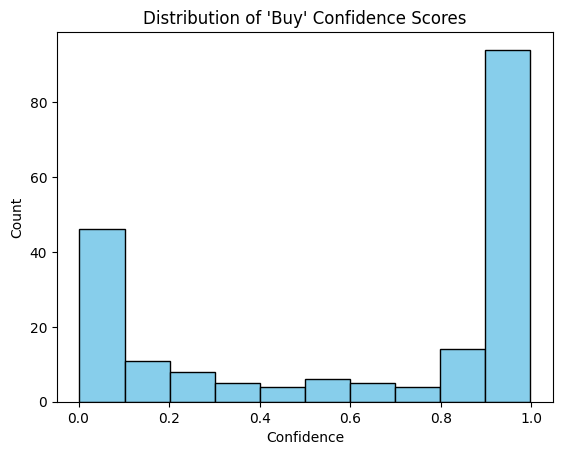

In [91]:
probs = model.predict_proba(X_test)[:, 1]  # Probability of class 1 ("Buy")
import matplotlib.pyplot as plt

plt.hist(probs, bins=10, color='skyblue', edgecolor='black')
plt.title("Distribution of 'Buy' Confidence Scores")
plt.xlabel("Confidence")
plt.ylabel("Count")
plt.show()


In [92]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(base_model, X, y, cv=5)
print("Cross-validated accuracy (raw base model):", np.mean(cv_scores))


Cross-validated accuracy (raw base model): 0.7914482544286748
